In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In [3]:
cancer = load_breast_cancer()
print(cancer.keys())
print(cancer.data.shape)
print(cancer.target_names)
print(np.unique(cancer.target))

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
(569, 30)
['malignant' 'benign']
[0 1]


In [4]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['diagnosis'] = cancer.target
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [5]:
print(df.describe())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

In [6]:
print(df.skew())

mean radius                0.942380
mean texture               0.650450
mean perimeter             0.990650
mean area                  1.645732
mean smoothness            0.456324
mean compactness           1.190123
mean concavity             1.401180
mean concave points        1.171180
mean symmetry              0.725609
mean fractal dimension     1.304489
radius error               3.088612
texture error              1.646444
perimeter error            3.443615
area error                 5.447186
smoothness error           2.314450
compactness error          1.902221
concavity error            5.110463
concave points error       1.444678
symmetry error             2.195133
fractal dimension error    3.923969
worst radius               1.103115
worst texture              0.498321
worst perimeter            1.128164
worst area                 1.859373
worst smoothness           0.415426
worst compactness          1.473555
worst concavity            1.150237
worst concave points       0

In [7]:
print(df.groupby('diagnosis').size())

diagnosis
0    212
1    357
dtype: int64


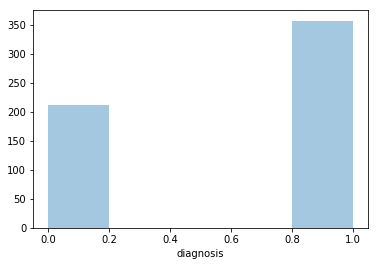

In [8]:
sns.distplot(df['diagnosis'], kde=False)

After we got a rough idea about the dataset, let us start to work on selecting features.

In [9]:
corr_mat = df.corr()
corr_with_target = corr_mat.iloc[-1]
corr_sorted = corr_with_target.sort_values(ascending=True)
print(corr_sorted)

worst concave points      -0.793566
worst perimeter           -0.782914
mean concave points       -0.776614
worst radius              -0.776454
mean perimeter            -0.742636
worst area                -0.733825
mean radius               -0.730029
mean area                 -0.708984
mean concavity            -0.696360
worst concavity           -0.659610
mean compactness          -0.596534
worst compactness         -0.590998
radius error              -0.567134
perimeter error           -0.556141
area error                -0.548236
worst texture             -0.456903
worst smoothness          -0.421465
worst symmetry            -0.416294
mean texture              -0.415185
concave points error      -0.408042
mean smoothness           -0.358560
mean symmetry             -0.330499
worst fractal dimension   -0.323872
compactness error         -0.292999
concavity error           -0.253730
fractal dimension error   -0.077972
symmetry error             0.006522
texture error              0

Given the above correlation between all features and the target (i.e., diagnosis), it is obvious that the features are redundant. It looks like the error features are not so useful compared to mean or worst features, so we first delete three least important error features: 'smoothness error', 'texture error' and 'symmetry error' from the bottom. Next, we also drop the feature 'mean fractal dimension', which has a really low correlation.   

In [10]:
new_df = df.drop(['smoothness error', 'mean fractal dimension', 'texture error', 'symmetry error'], axis=1)
print(new_df.shape)

(569, 27)


In [11]:
X = new_df.drop(['diagnosis'], axis=1)
y = new_df['diagnosis']

There are still too many redundant features, we then use feature_selection.SelectPercentile to take half of them.  

In [12]:
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

In [13]:
features_selected = []
for flag, name in zip(select.get_support(), X.columns):
    if flag:
        features_selected.append(name)

In [14]:
print(features_selected)

['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In this list of selected features, we got the features 'mean radius', 'radius error' and 'worst radius'. We think choosing two of them is enough for the classification problem. So we drop 'radius error', which has the lowest correlation among these 3 features describing radius.  

In [15]:
features_selected.remove('radius error')
print(len(features_selected))

12


It has 12 features after feature_selection, and there still could be some room for cutting the number of features. But we keep it as is and use 12 features to make a dataframe for further study. 

In [16]:
df_selected = X.loc[:, features_selected]
df_selected['diagnosis'] = y
print(df_selected.head())

   mean radius  mean perimeter  mean area  mean compactness  mean concavity  \
0        17.99          122.80     1001.0           0.27760          0.3001   
1        20.57          132.90     1326.0           0.07864          0.0869   
2        19.69          130.00     1203.0           0.15990          0.1974   
3        11.42           77.58      386.1           0.28390          0.2414   
4        20.29          135.10     1297.0           0.13280          0.1980   

   mean concave points  worst radius  worst perimeter  worst area  \
0              0.14710         25.38           184.60      2019.0   
1              0.07017         24.99           158.80      1956.0   
2              0.12790         23.57           152.50      1709.0   
3              0.10520         14.91            98.87       567.7   
4              0.10430         22.54           152.20      1575.0   

   worst compactness  worst concavity  worst concave points  diagnosis  
0             0.6656           0.7119

We break the dataframe into two parts and visualize the selected features, remember 0 for 'malignant' and 1 for 'benign'.

In [17]:
malignant = df_selected[df_selected['diagnosis'] == 0]
benign = df_selected[df_selected['diagnosis'] == 1]

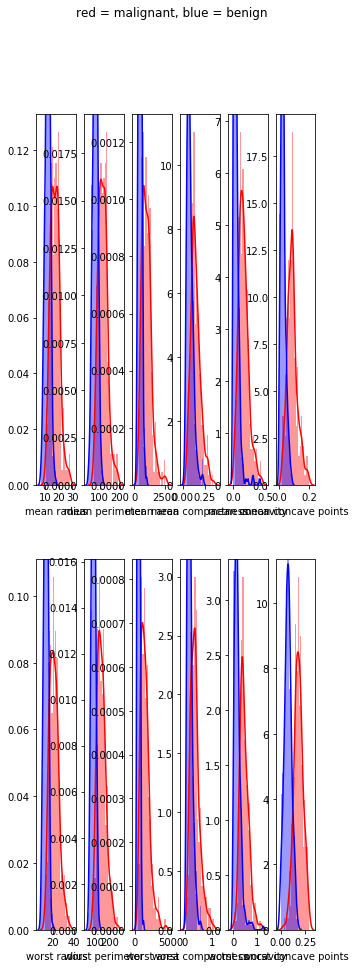

In [18]:
fig, ax = plt.subplots(2, 6, figsize=(5, 15))

ax = ax.ravel()

plt.suptitle('red = malignant, blue = benign')

for i, name in enumerate(features_selected):
    sns.distplot(malignant[name], bins=20, color='r', ax=ax[i])
    sns.distplot(benign[name], bins=20, color='b', ax=ax[i])

[Text(0,0.5,'mean radius'),
 Text(0,1.5,'mean perimeter'),
 Text(0,2.5,'mean area'),
 Text(0,3.5,'mean compactness'),
 Text(0,4.5,'mean concavity'),
 Text(0,5.5,'mean concave points'),
 Text(0,6.5,'worst radius'),
 Text(0,7.5,'worst perimeter'),
 Text(0,8.5,'worst area'),
 Text(0,9.5,'worst compactness'),
 Text(0,10.5,'worst concavity'),
 Text(0,11.5,'worst concave points'),
 Text(0,12.5,'diagnosis')]

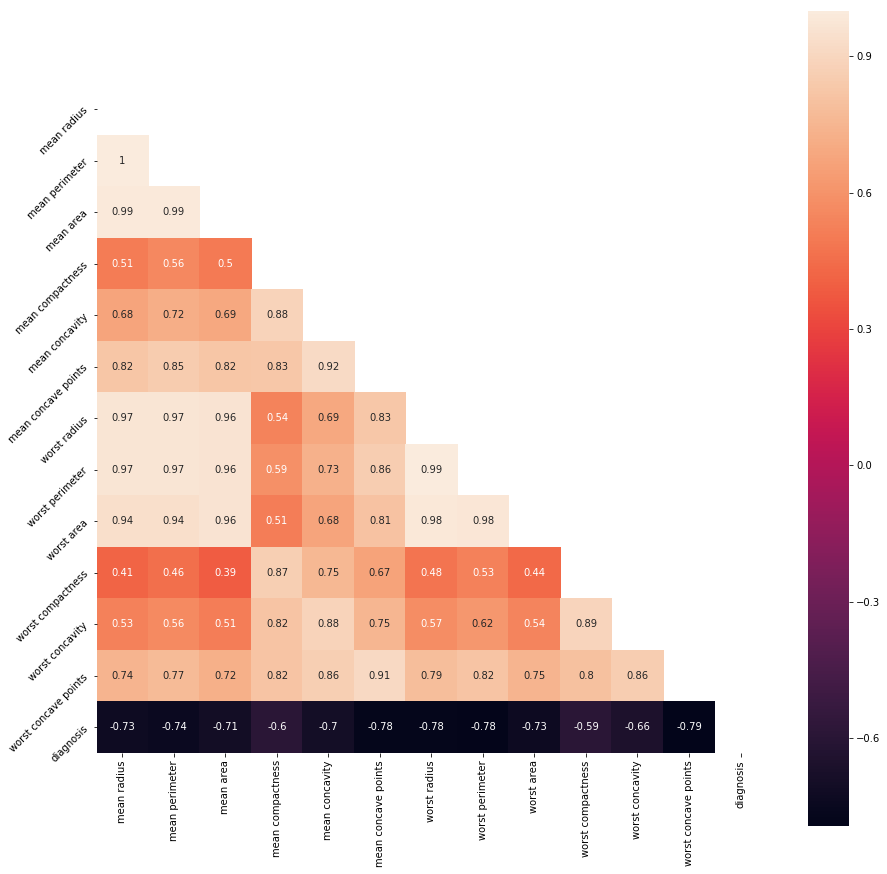

In [21]:
corr = df_selected.corr()
features_selected.append('diagnosis')

plt.figure(figsize=(15, 15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, square=True, annot=True, mask=mask)
ax.set_xticklabels(labels=features_selected, rotation=90)
ax.set_yticklabels(labels=features_selected, rotation=45)

For some sample features, we also do the pairplot.

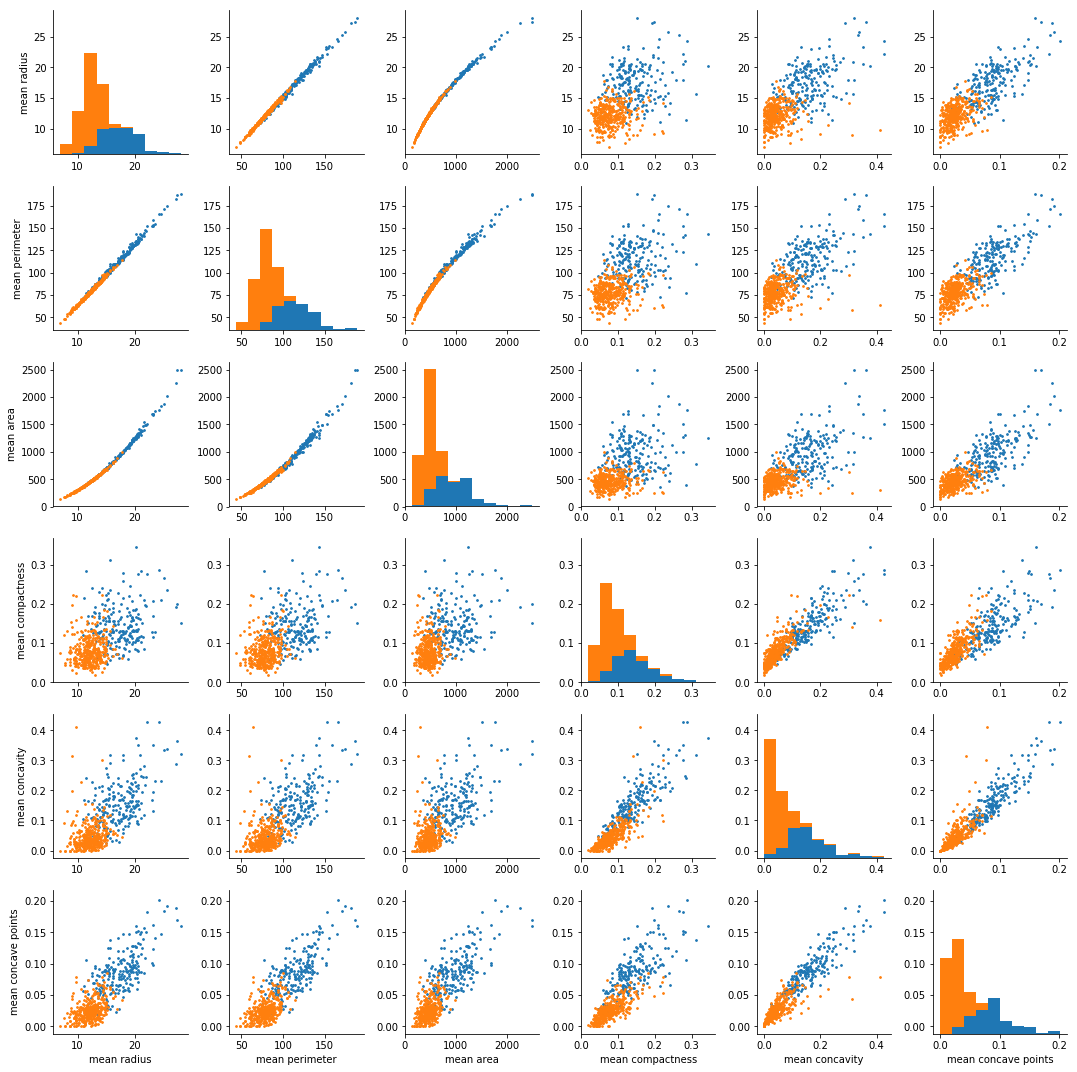

In [20]:
sample_features = features_selected[:6]
g = sns.PairGrid(vars=sample_features, hue='diagnosis', data=df_selected)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s=3)

Let us do a baseline prediction by kNN.

In [22]:
X_selected = df_selected.drop(['diagnosis'], axis=1)
y_selected = df_selected['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, random_state=1)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
print('score of k-Nearest Neighbor: {}'.format(clf.score(X_test, y_test)))

score of k-Nearest Neighbor: 0.9370629370629371


It turns out that kNN already got a good score, and we expect SVM can do better after standard scaling. 

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train_scaled, y_train)
print('score of SVM after standard scaling: {}'.format(svm.score(X_test_scaled, y_test)))

score of SVM after standard scaling: 0.951048951048951


One can try cross validation to see that a high score of SVM is independent of the train_test_split.

In [26]:
from sklearn.model_selection import cross_val_score

X_selected_scaled = scaler.fit_transform(X_selected)
scores = cross_val_score(svm, X_selected_scaled, y_selected, cv=3)
print('scores of SVM using cross validation: {}'.format(scores))

scores of SVM using cross validation: [ 0.92105263  0.94736842  0.95238095]


Finally, we can apply a grid search to figure out the best parameters for a SVM.

In [27]:
from sklearn.model_selection import GridSearchCV

list_kernels = ['linear', 'rbf', 'poly', 'sigmoid']
params = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel': list_kernels}

grid = GridSearchCV(estimator=svm, param_grid=params, cv=5)
grid = grid.fit(X_train_scaled, y_train)
print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 0.10000000000000001, 'kernel': 'rbf'} with a score of 0.960094


In [28]:
grid.best_estimator_.probability = True
best_svm = grid.best_estimator_
best_svm.fit(X_train_scaled, y_train)
y_pred = best_svm.predict(X_test_scaled)
print('score of SVM after tuning parameters on the training set: {}'.format(best_svm.score(X_train_scaled, y_train)))
print('score of SVM after tuning parameters on the test set:     {}'.format(best_svm.score(X_test_scaled, y_test)))

score of SVM after tuning parameters on the training set: 0.9882629107981221
score of SVM after tuning parameters on the test set:     0.9440559440559441


Thus SVM did a great job on the breast cancer prediction problem. In healthcare, there are other metrics compared to the accuracy score. For example, let us check the confusion matrix of the best SVM, then we will take a look at the ROC_AUC_score.

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.89      0.92        55
          1       0.93      0.98      0.96        88

avg / total       0.94      0.94      0.94       143



Text(0,0.5,'True values')

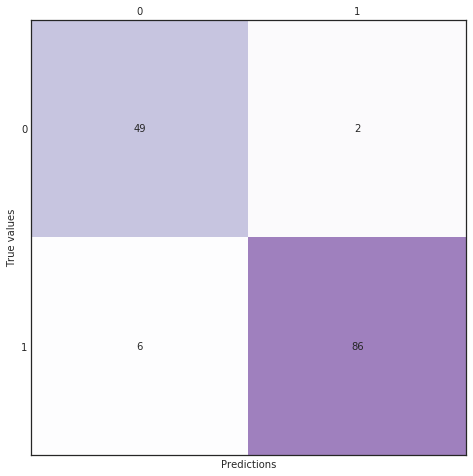

In [30]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap='Purples', alpha=0.5)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=i, y=j, s=cm[i, j], va='center', ha='center')
ax.set_xlabel('Predictions')
ax.set_ylabel('True values')

In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

print('The accuracy score of the best SVM is: {}'.format(accuracy_score(y_test, y_pred)))
print('The ROC/AUC score of the best SVM is:  {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score of the best SVM is: 0.9440559440559441
The ROC/AUC score of the best SVM is:  0.9340909090909091


Text(0.5,1,'Receiver Operating Characteristic (ROC)')

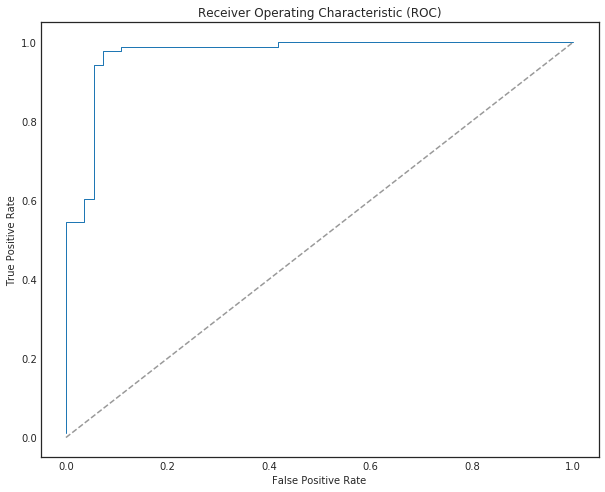

In [32]:
plt.figure(figsize=(10, 8))
probas = best_svm.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')